In [1]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import wordninja
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords

In [2]:
l_data = pd.read_csv('../data/liberal_results_df.csv')
c_data = pd.read_csv('../data/conservative_results.csv')               


In [3]:


l_data.drop(l_data.index[[1741]], inplace=True)# during eda it was discovered that this cell contained unusable data.


In [4]:
l_data['selftext'] = l_data['selftext'].fillna('[removed]')
c_data['selftext'] = c_data['selftext'].fillna('[removed]')# fill empty columns with removed 


In [5]:
l_data['selftext'] = l_data['selftext'].apply(lambda x : x.replace('[removed]',''))
c_data['selftext'] = c_data['selftext'].apply(lambda x : x.replace('[removed]',''))#remove empty columns


In [6]:
l_data['fulltext'] = l_data['title'] + ' ' + l_data['selftext']
c_data['fulltext'] = c_data['title'] + ' ' + c_data['selftext']# combine text from title and selftext


In [7]:
c_categorical_nums = {"subreddit": {'Conservative': 1}}#make classification categories
l_categorical_nums = {"subreddit": {'Liberal': 0}}
c_data.replace(c_categorical_nums, inplace=True)
l_data.replace(l_categorical_nums, inplace=True)

In [8]:
def get_len(post):
    return len(post.split())
l_data['post_len'] = l_data['fulltext'].map(get_len)# create a column that has the length of the posts
c_data['post_len'] = c_data['fulltext'].map(get_len)
#courtesy of markel jones-francis


In [9]:
l_data['author'] = l_data['author'].apply(lambda x : x.replace('[deleted]',' '))
c_data['author'] = c_data['author'].apply(lambda x : x.replace('[deleted]',' '))# delete empty author entries


In [10]:
def remove_links_lower_and_nums(data,col):
    string = []
    letters = []
    remove_links = []
    lower = []
    for i in data[col]:
        string.append(str(i))
    for j in string:
        letters.append(re.sub(r'[^A-Za-z0-9 ]+', "", j))#remove letters and number
    for k in letters:
        remove_links.append(re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b','',k))#remove links
    return lower
    l_data['fulltext'] = remove_links_lower_and_nums(l_data,'fulltext')
    c_data['fulltext'] = remove_links_lower_and_nums(c_data,'fulltext')



In [11]:
def make_str_remove_non_letters_lower(data,col):
    string = []
    for i in data[col]:
        string.append(str(i))
    long_words = []
    for i in string:
        long_words.append(re.sub(r'/.{20,}/','',i))#remove words longer than 20 chars
    lower = []
    for i in long_words:
        lower.append(i.lower())
    return lower
l_data['fulltext'] = make_str_remove_non_letters_lower(l_data,'fulltext')
c_data['fulltext'] = make_str_remove_non_letters_lower(c_data,'fulltext')

    


In [12]:
def remove_nums(data,col):# during eda we discovered that a lot of numeric columns has corrupted or non valuble data
    data[col] = data[col].str.replace(r'\d+','')
remove_nums(c_data,'fulltext')
remove_nums(l_data,'fulltext')

In [13]:
def remove_underscores(data,col):# during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('_',' ')
remove_underscores(c_data,'fulltext')
remove_underscores(l_data,'fulltext')

In [14]:
def remove_link_words(data,col): # during eda we discovered that underscores were corrupting the values
    data[col] = data[col].str.replace('https','')
    data[col] = data[col].str.replace('http','')
remove_link_words(c_data,'fulltext')
remove_link_words(l_data,'fulltext')

Text(12, 0, '       Average Length of a Post 61.5 Char')

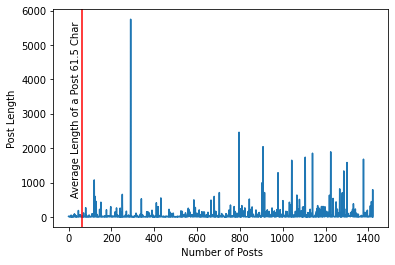

In [15]:
(c_data['post_len'].plot()) 
plt.xlabel(' Number of Posts')
plt.ylabel('Post Length')
plt.axvline(x=(c_data['post_len'].mean()),color = 'r')
plt.text(12,0, '       Average Length of a Post 61.5 Char',rotation=90)

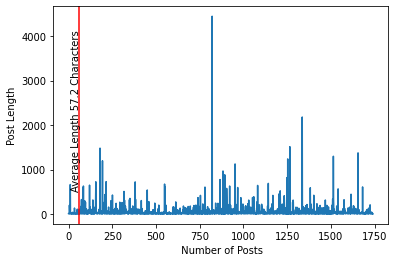

<Figure size 720x1296 with 0 Axes>

In [16]:
(l_data['post_len'].plot()) 
plt.xlabel(' Number of Posts')
plt.ylabel('Post Length')
plt.axvline(x=(l_data['post_len'].mean()),color = 'r')
plt.text(12,0, '        Average Length 57.2 Characters',rotation=90)
plt.figure(figsize=(10,18))
plt.show()

In [17]:
from better_profanity import profanity
def profanity_counter(data,col):
    counter = 0
    for i in data[col]:
        if profanity.contains_profanity(i) == True:
            counter += 1
    return counter
l_swear = profanity_counter(l_data,'fulltext')
c_swear = profanity_counter(c_data,'fulltext')   



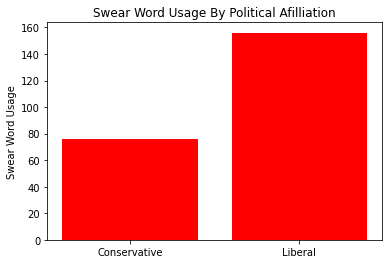

In [18]:
x = ['Conservative', 'Liberal']
y = [76,156]
plt.bar(x,y,color = 'r');
plt.ylabel('Swear Word Usage')
plt.title('Swear Word Usage By Political Afilliation');

In [19]:
both_df = c_data[c_data['author'].isin(l_data['author'])]
both_df = both_df[both_df['author'] != ' ']



In [20]:
top_N = 10

txt = both_df.fulltext.str.lower().str.replace(r'[^A-Za-z0-9 ]+', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['the','of','to','in','than','$','?','(',')''is','for','us','amp']
stopwords.extend(newStopWords)
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

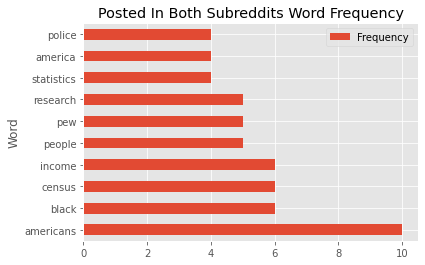

In [21]:
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Common Word', 'Frequency'])

rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')

plt.style.use('ggplot')

rslt.plot.barh(rot=0,title = 'Posted In Both Subreddits Word Frequency',);
# adapted from https://stackoverflow.com/questions/40206249/count-of-most-popular-words-in-a-pandas-dataframe

In [22]:
c_combine  = c_data.copy()
l_combine = l_data.copy()


In [23]:
cvec = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = stopwords,
                       
                             max_features = 50000)

In [24]:
l_data = cvec.fit_transform(l_data['fulltext'])
l_df = pd.DataFrame(l_data.toarray(),
                          columns=cvec.get_feature_names())


In [25]:
c_data = cvec.fit_transform(c_data['fulltext'])
c_df = pd.DataFrame(c_data.toarray(),
                          columns=cvec.get_feature_names())

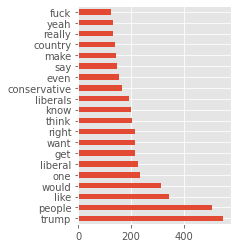

In [56]:
plt.plot(1, 2, 1)
c_df.sum()[c_df.sum()>=100].sort_values(ascending=False).plot(kind='barh');
plt.subplot(1,2,2)
l_df.sum()[l_df.sum()>=125].sort_values(ascending=False).plot(kind='barh');

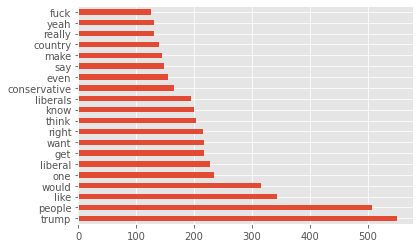

In [27]:
l_df.sum()[l_df.sum()>=125].sort_values(ascending=False).plot(kind='barh');

In [28]:
full_df = pd.concat([l_combine,c_combine])


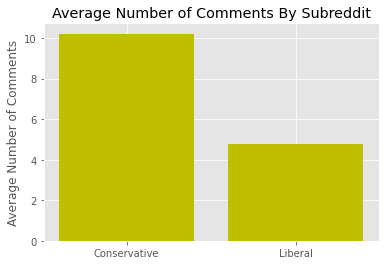

In [29]:
#plt.bar(full_df['subreddit'],full_df['num_comments'].mean())
full_df[full_df['subreddit']==0]['num_comments'].mean()
x = ['Conservative', 'Liberal']
y = [full_df[full_df['subreddit']==1]['num_comments'].mean(),full_df[full_df['subreddit']==0]['num_comments'].mean()]
plt.bar(x,y,color = 'y');
plt.ylabel('Average Number of Comments')
plt.title('Average Number of Comments By Subreddit');

In [30]:
#[1 else 0 if profanity.contains_profanity(i) == Truefor i in full_df] 
for i in full_df['fulltext']:
    if profanity.contains_profanity(i) == True:
        full_df['contain_profanity'] = 1
    else:
        full_df['contain_profanity'] = 0
        
       
      
full_df['contain_profanity'].value_counts(normalize=True)


0    1.0
Name: contain_profanity, dtype: float64

In [49]:
X = full_df['fulltext']
y = full_df['subreddit']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
             
                                                    stratify=y,
                                                    random_state=42)

In [51]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

ValueError: could not convert string to float: "i just posted 'american isn't the greatest nation ever, nor is it particularly great' on change my view. jesus christ. "

In [33]:
y_test.value_counts(normalize=True)

0    0.550766
1    0.449234
Name: subreddit, dtype: float64

In [34]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [35]:
pipe_params = {
    'cvec__min_df': [1,2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2),(1,3)]
}

In [36]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [37]:
(gs.fit(X_train,y_train))

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarni

/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarni

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [38]:
gs.best_params_


{'cvec__max_df': 0.9, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}

In [48]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X_train, y_train).mean()}')


Train Score 0.7404436054742803
Test Score 0.6206896551724138


/Users/aryehgelfand/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cross Val Score 0.6205643664670418


In [40]:
pipe = Pipeline([
    ('tvec' , TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [41]:
pipe_params = {
    'tvec__max_features': [100,500],
    'tvec__stop_words': ['english',None],
    'tvec__ngram_range': [(1,1), (1,2)],
}

In [42]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [43]:
(gs.fit(X_train,y_train))
gs.best_params_

{'tvec__max_features': 500,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [44]:
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')

Train Score 0.7404436054742803
Test Score 0.6206896551724138


In [45]:
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

ValueError: could not convert string to float: "i just posted 'american isn't the greatest nation ever, nor is it particularly great' on change my view. jesus christ. "

In [ ]:
knn = KNeighborsClassifier()
knn.get_params().keys()

In [ ]:
pipe = Pipeline([
    ('knn' ,KNeighborsClassifier())
])

In [ ]:
pipe_params = {
    'knn__n_neighbors': [3,5,7,9],
    'knn__metric_params': ['manhattan','euclidean','minkowski']
    
}

In [ ]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [ ]:
gs.fit(X_train,y_train)